In [1]:
import cooler
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
from scipy.stats import mannwhitneyu
from mpl_toolkits.axes_grid1 import make_axes_locatable
import bioframe
import matplotlib.pyplot as plt
from matplotlib import font_manager
import cooltools
from cooltools import insulation
from skimage.filters import threshold_li, threshold_otsu
from scipy.stats import ttest_ind

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial'] 
plt.rcParams['pdf.fonttype'] = 42
font_files = font_manager.findSystemFonts(fontpaths='/cluster/home/futing/miniforge-pypy3/envs/HiC/fonts/')
 
for file in font_files:
    font_manager.fontManager.addfont(file)

### insulaion BS的分布

In [2]:
# 加载 insulation score 数据
df = pd.read_csv("/cluster2/home/futing/Project/panCancer/CRC/GSE137188/09-376/anno/insul/09-376_5000.tsv", sep="\t")
df.head()

,chrom,start,end,region,is_bad_bin,log2_insulation_score_25000,n_valid_pixels_25000,boundary_strength_25000,is_boundary_25000
0,chr1,0,5000,chr1,True,NaN,0.0,NaN,False
1,chr1,5000,10000,chr1,True,NaN,0.0,NaN,False
2,chr1,10000,15000,chr1,True,NaN,0.0,NaN,False
3,chr1,15000,20000,chr1,True,NaN,0.0,NaN,False
4,chr1,20000,25000,chr1,True,NaN,0.0,NaN,False


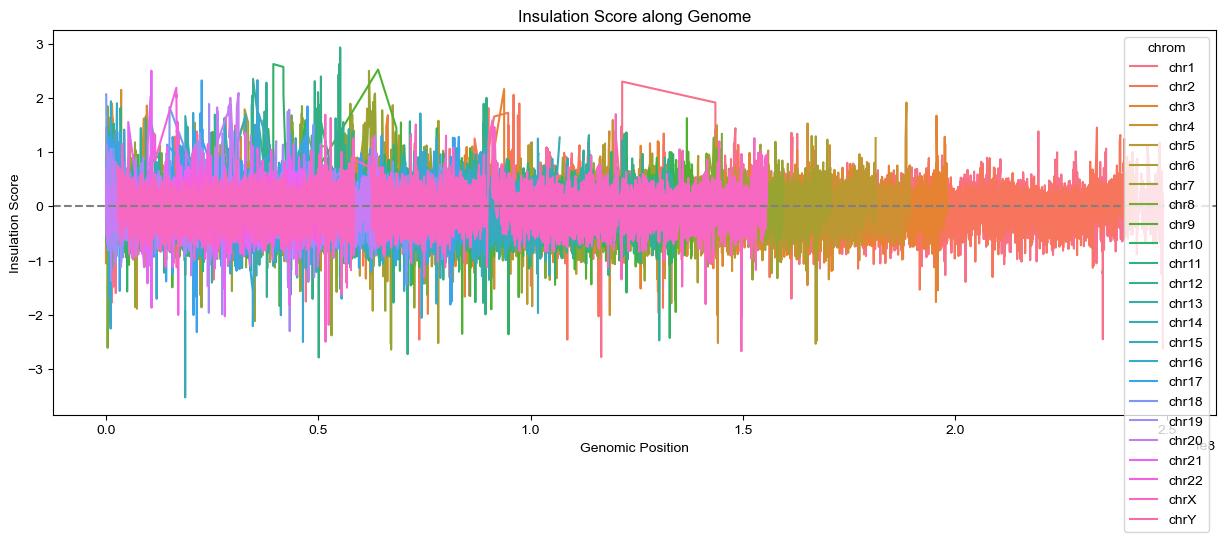

In [ ]:
# 绘制 insulation score 曲线
plt.figure(figsize=(15, 5))
sns.lineplot(data=df, x="start", y="log2_insulation_score_25000", hue="chrom")
plt.axhline(y=0, color="gray", linestyle="--")  # 参考线
plt.title("Insulation Score along Genome")
plt.xlabel("Genomic Position")
plt.ylabel("Insulation Score")
plt.savefig("/cluster2/home/futing/Project/panCancer/CRC/GSE137188/09-376/anno/insul/insulation_curve.png")


In [3]:
%cd /cluster2/home/futing/Project/panCancer/CRC/GSE137188/09-376/anno/insul

/cluster2/home/futing/Project/panCancer/CRC/GSE137188/09-376/anno/insul


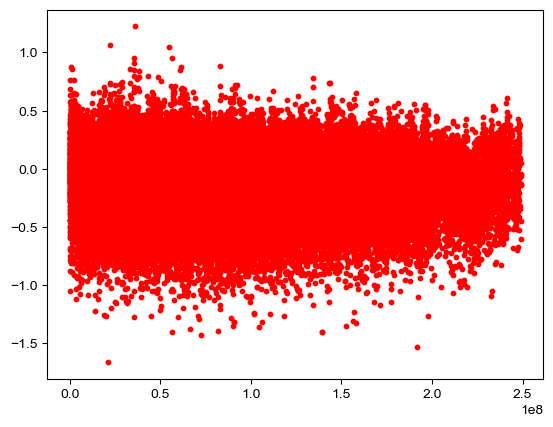

In [ ]:
# 筛选边界区域（is_boundary=True）并绘制
boundaries = df[df["is_boundary_25000"] == True]
plt.scatter(boundaries["start"], boundaries["log2_insulation_score_25000"], color="red", s=10)
plt.savefig("diamond_insulation.png")top

### 样本个数

In [ ]:
meta=pd.read_csv('/cluster2/home/futing/Project/panCancer/check/hic/insul0910.txt',sep='\t',header=None)
meta.columns=['cancer','gse','cell','ncell']


/tmp/ipykernel_35051/1625119151.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(
INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:LTSH dropped
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:PCLT dropped
INFO:fontTools.subset:JSTF dropped
INFO:fontTools.subset:DSIG dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 45 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'E', 'G', 'H', 'L', 'M', 'N', 'O', 'P', 'R', 'S', 'T', 'U', 'V', 'a', 'b', 'c', 'e', 'eight', 'five', 'four', 'hyphen', 'i', 'n', 'nine', 'nonmarkingreturn', 'o', 'one', 'p', 'r', 's', '

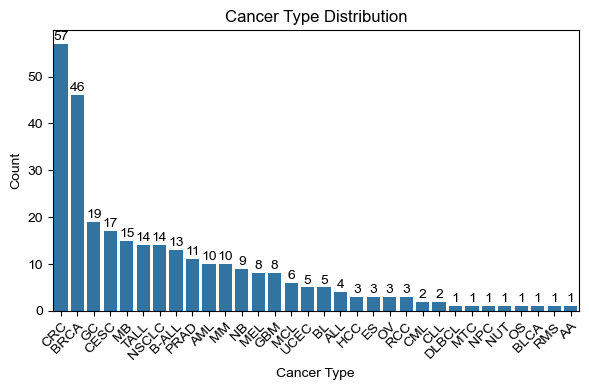

In [ ]:
# sample counts

nsample = meta[['cancer','cell']].drop_duplicates().drop(columns=['cell']).value_counts().reset_index()
fig,ax=plt.subplots(figsize=(6,4))
ax = sns.barplot(x=nsample['cancer'], y=nsample['count'])

plt.title("Cancer Type Distribution")
plt.xlabel("Cancer Type")
plt.ylabel("Count")

# 调整标签对齐
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    ha='right',
	rotation_mode='anchor'
)

# 在每个柱子上方添加数值
for p in ax.patches:
    ax.annotate(
        f"{p.get_height():.0f}",  # 显示整数，去掉小数
        (p.get_x() + p.get_width() / 2., p.get_height()),  # 位置（x, y）
        ha='center',  # 水平居中
        va='center',  # 垂直居中
        xytext=(0, 5),  # 文字偏移量（x, y）
        textcoords='offset points'  # 坐标单位（点）
    )


plt.tight_layout()
plt.savefig('/cluster2/home/futing/Project/panCancer/QC/nsample337.pdf',dpi=300)

### 相关性热图	
*	insulation	
*	boundary

In [9]:
insul=pd.read_csv('/cluster2/home/futing/Project/panCancer/QC/insul/cancer_Jun26.bed',sep='\t')
insul=insul.drop(columns=['chrom','start','end'])

In [10]:
def drop_half_na_rows(df):
    # 计算每行NA值的比例
    na_ratio = df.isna().mean(axis=1)
    # 保留NA比例小于0.5的行
    return df[na_ratio < 0.3]
insul_fil = drop_half_na_rows(insul)

In [6]:
sample_similarity.head()

,09-376,11-1026,11-1074,11-1074_Normal,11-51,11-51_Normal,11-52,11-52_Normal,11-63,11-63_Normal,...,Jurkat.1,primary_TALL_cells,Tcell1,Tcell2,Tcell3,CCRF-CEM,Jurkat.2,MOLT-4,RPMI-8402,Tcell_leukemia_cell
09-376,1.000000,0.366912,0.392421,0.397204,0.256242,0.262878,0.372388,0.397090,0.393637,0.385401,...,0.180030,0.374502,0.134833,0.072583,0.269897,0.230616,0.293412,0.232313,0.286696,0.289756
11-1026,0.366912,1.000000,0.453422,0.414372,0.301295,0.277204,0.443798,0.423803,0.437606,0.398833,...,0.186102,0.409254,0.138297,0.078140,0.280797,0.257483,0.314005,0.254425,0.315656,0.328054
11-1074,0.392421,0.453422,1.000000,0.447838,0.313753,0.288118,0.474218,0.454752,0.481304,0.425739,...,0.194902,0.438435,0.144079,0.079760,0.294882,0.276845,0.335713,0.269957,0.336466,0.342429
11-1074_Normal,0.397204,0.414372,0.447838,1.000000,0.294564,0.271564,0.436651,0.493238,0.454269,0.457828,...,0.195512,0.363592,0.148381,0.040492,0.294570,0.199585,0.279931,0.221747,0.281927,0.260797
11-51,0.256242,0.301295,0.313753,0.294564,1.000000,0.202809,0.307395,0.298695,0.306532,0.280376,...,0.135961,0.291291,0.106129,0.061097,0.203240,0.185681,0.226563,0.181671,0.221043,0.230422


In [11]:
nsample.index

Index(['CRC', 'MB', 'TALL'], dtype='object', name='cancer')

[Text(1, 0.5, 'MB244'),
 Text(1, 1.5, 'MB227'),
 Text(1, 2.5, 'MB268'),
 Text(1, 3.5, 'MB164'),
 Text(1, 4.5, 'MB264'),
 Text(1, 5.5, 'MB102'),
 Text(1, 6.5, 'MB106'),
 Text(1, 7.5, 'MB234'),
 Text(1, 8.5, 'MB174'),
 Text(1, 9.5, 'MB199'),
 Text(1, 10.5, 'CCRF-CEM'),
 Text(1, 11.5, 'MOLT-4'),
 Text(1, 12.5, 'Jurkat'),
 Text(1, 13.5, 'TALL_patient_xenograft'),
 Text(1, 14.5, 'primary_TALL_cells'),
 Text(1, 15.5, 'HCT116'),
 Text(1, 16.5, 'CUTLL1'),
 Text(1, 17.5, 'CUTLL1_1'),
 Text(1, 18.5, 'Tcell_leukemia_cell'),
 Text(1, 19.5, 'Jurkat.2'),
 Text(1, 20.5, 'RPMI-8402'),
 Text(1, 21.5, '15-418'),
 Text(1, 22.5, '13-1483'),
 Text(1, 23.5, '14-328'),
 Text(1, 24.5, '14-91'),
 Text(1, 25.5, '13-1317'),
 Text(1, 26.5, '14-114'),
 Text(1, 27.5, '14-258'),
 Text(1, 28.5, '13-731'),
 Text(1, 29.5, '16-178'),
 Text(1, 30.5, '12-251_Normal'),
 Text(1, 31.5, '11-1074_Normal'),
 Text(1, 32.5, '11-52_Normal'),
 Text(1, 33.5, '13-545'),
 Text(1, 34.5, '11-927'),
 Text(1, 35.5, '13-1334'),
 Text(1, 36

<Figure size 1400x1000 with 0 Axes>

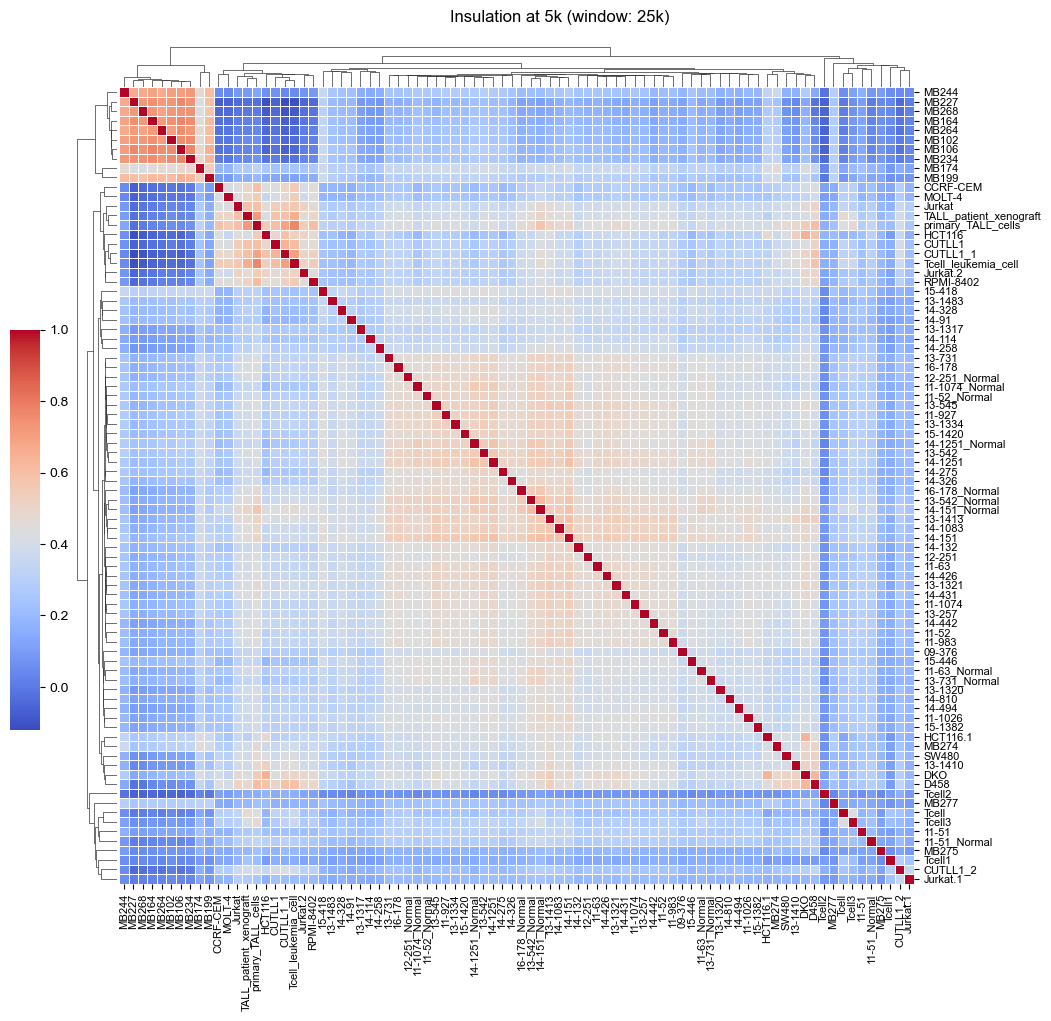

In [ ]:

sample_similarity = insul_fil.corr()
plt.figure(figsize=(14, 10))
g = sns.clustermap(sample_similarity ,cmap='coolwarm', annot=False, fmt=".2f", linewidths=0.5,
                    dendrogram_ratio=(0.05, 0.05),   
                    cbar_pos=(-0.05, 0.3, 0.03, 0.4))

# 设置标题
plt.suptitle('Insulation at 5k (window: 25k)', fontsize=12, y=1.02)
rows, cols = sample_similarity.shape
group_labels = nsample.index
# ---- 手动设置标签，否则会被折叠
# 手动设置刻度，确保它们位于每个格子的中心
g.ax_heatmap.set_xticks(np.arange(cols) + 0.5)
g.ax_heatmap.set_yticks(np.arange(rows) + 0.5)
for _, spine in g.ax_heatmap.spines.items():
    spine.set_visible(False)
# 获取行和列的聚类结果（重新排序后的索引）
row_order = g.dendrogram_row.reordered_ind
col_order = g.dendrogram_col.reordered_ind

# 获取重新排序后的行和列标签
row_labels = [sample_similarity.index[i] for i in row_order]
col_labels = [sample_similarity.columns[i] for i in col_order]

# 设置 x 轴和 y 轴的标签
g.ax_heatmap.set_xticklabels(row_labels,  fontsize=8) #rotation=45, ha='right',
g.ax_heatmap.set_yticklabels(row_labels, fontsize=8)
# plt.savefig(f'/cluster2/home/futing/Project/panCancer/QC/insul/insul.pdf', format='pdf', dpi=300, bbox_inches='tight', pad_inches=0.5)

### 散点图

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import umap.umap_ as umap
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

data=E1_fil.T # 列是特征
data_imputed=data.fillna(0)
# imputer = SimpleImputer(strategy='mean')
# data_imputed = imputer.fit_transform(data)


pca = PCA(n_components=20, random_state=42)
data_pca = pca.fit_transform(data_imputed)
umap_instance = umap.UMAP(n_neighbors=15,min_dist=0.1,  n_components=2, random_state=42)
umap_transformed = umap_instance.fit_transform(data_pca)

# 对UMAP降维后的数据进行KMeans聚类
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(umap_transformed)
umaplabels = kmeans.labels_

kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(data_pca)
pcalabels = kmeans.labels_


/cluster/home/futing/miniforge-pypy3/envs/hic/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [ ]:
pca_result=pd.DataFrame(data_pca,columns=[f'PC{i+1}' for i in range(20)])
pca_result.index=E1_fil.columns
pca_result['kmeans']=pcalabels
pca_result=pd.merge(pca_result,meta,left_index=True,right_index=True)
pca_result.to_csv('/cluster/home/futing/Project/GBM/HiC/09insulation/00plot/PC1/scatter/PC1_python_kmeans.txt',sep='\t')

In [ ]:
umap_result=pd.DataFrame(umap_transformed,columns=[f'UMAP{i+1}' for i in range(2)])
umap_result.index=E1_fil.columns
umap_result['kmeans']=umaplabels
umap_result=pd.merge(umap_result,meta,left_index=True,right_index=True)
umap_result.to_csv('/cluster/home/futing/Project/GBM/HiC/09insulation/00plot/PC1/scatter/UMAP_python_kmeans.txt',sep='\t')

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:LTSH dropped
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern pruned
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:PCLT dropped
INFO:fontTools.subset:JSTF dropped
INFO:fontTools.subset:DSIG dropped
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 31 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'C', 'D', 'J', 'L', 'M', 'P', 'X', 'a', 'b', 'd', 'e', 'g', 'h', 'i', 'l', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'r', 's', 'space', 't', 'three', 'two', 'u', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 22, 38, 39, 45, 47, 48, 51, 59, 68, 69, 71, 72, 74, 75, 76, 79, 81, 82, 83, 85, 86, 87, 88, 237]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 31 glyphs after
INFO:fontTools.subset:Gly

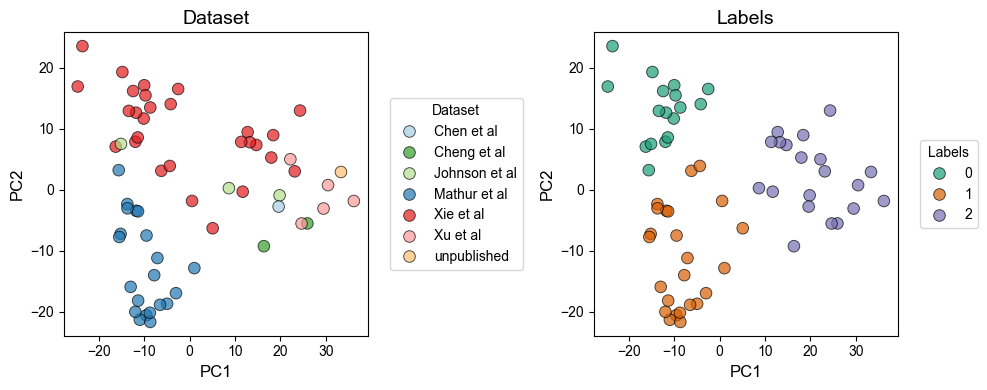

In [ ]:

mypalette = ['#a6cee3','#33a02c','#b2df8a','#1f78b4','#e31a1c','#fb9a99','#fdbf6f']
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# 左边的图：根据 'dataset' 上色
sns.scatterplot(x=data_pca[:, 0], y=data_pca[:, 1], 
                hue=meta['dataset'], palette=mypalette, ax=axes[0],s=70, alpha=0.7, edgecolor='k')

axes[0].set_title('Dataset', fontsize=14)
axes[0].set_xlabel('PC1', fontsize=12)
axes[0].set_ylabel('PC2', fontsize=12)

# 右边的图：根据 'labels' 上色
sns.scatterplot(x=data_pca[:, 0], y=data_pca[:, 1], 
                hue=pcalabels, palette="Dark2", ax=axes[1],s=70, alpha=0.7, edgecolor='k')

axes[1].set_title('Labels', fontsize=14)
axes[1].set_xlabel('PC1', fontsize=12)
axes[1].set_ylabel('PC2', fontsize=12)

# 调整两个图例，统一放置在右边
# 第一个图例：Dataset
axes[0].legend(title='Dataset', bbox_to_anchor=(1.05, 0.5), loc='center left')

# 第二个图例：Labels
axes[1].legend(title='Labels', bbox_to_anchor=(1.05, 0.5), loc='center left')

# 调整布局
plt.tight_layout()
plt.savefig(f'/cluster/home/futing/Project/GBM/HiC/09insulation/00plot/PC1/scatter/PC1_python_kmeans.pdf', format='pdf', dpi=500, bbox_inches='tight', pad_inches=0.5)